In [13]:
import torch

### LNovelD

In [2]:
from model.modules.lnoveld import LNovelD

m = LNovelD(2, 2, 5)

In [3]:
m

LNovelD(
  (obs_noveld): NovelD(
    (target): MLPNetwork(
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=64, bias=True)
        (1): ReLU()
        (2): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU()
        )
        (3): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU()
        )
        (4): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU()
        )
        (5): Linear(in_features=64, out_features=5, bias=True)
      )
    )
    (predictor): MLPNetwork(
      (mlp): Sequential(
        (0): Linear(in_features=2, out_features=64, bias=True)
        (1): ReLU()
        (2): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU()
        )
        (3): Sequential(
          (0): Linear(in_features=64, out_features=64, bias=True)
          (1): ReLU()
        )
    

In [5]:
obs = torch.Tensor([[10.0, 10.0]])
m(obs, None)


target tensor([[-1.8384,  0.9695, -3.8054, -2.1500,  3.6722]])
pred tensor([[ 2.2023, -4.3319, -0.7381, -3.4516,  0.7183]],
       grad_fn=<AddmmBackward0>)
nov tensor([8.0162])
last nov tensor([0.8016])
comp tensor([-3.2065])
7.615405559539795


7.615405559539795

In [6]:
m.obs_noveld.episode_states_count

{(1.0, 1.0): 1, (10.0, 10.0): 1}

### Encoder

In [1]:
import torch
from model.modules.lm import GRUEncoder, OneHotEncoder

gru = GRUEncoder(
    10, 
    OneHotEncoder(['South','Not','Located','West','Object','Landmark','North','Center','East']))

opt = torch.optim.Adam(gru.gru.parameters(), lr=0.1)

sentences = [
    ["Located", "South"], 
    ["Located", "Center", "Object", "East"], 
    ["Located", "South"], 
    ["Located", "East", "Object", "South", "East"], 
    ["Located", "South", "West"]
]
sentences = [["<SOS>"] + s + ["<EOS>"] for s in sentences]

encs = gru(sentences)
gru(sentences)


tensor([[[ 0.0602, -0.1766, -0.0372,  0.1486,  0.3524,  0.0492, -0.0064,
           0.1933, -0.3469, -0.0596],
         [ 0.1362, -0.3001,  0.0173,  0.2752,  0.3259, -0.0171,  0.0233,
           0.0974, -0.2904, -0.0622],
         [ 0.0602, -0.1766, -0.0372,  0.1486,  0.3524,  0.0492, -0.0064,
           0.1933, -0.3469, -0.0596],
         [ 0.1281, -0.2525,  0.0050,  0.2414,  0.3356,  0.0387,  0.0285,
           0.1468, -0.3164, -0.0694],
         [ 0.1491, -0.2382,  0.0952,  0.1408,  0.3274,  0.1251, -0.0039,
           0.1219, -0.3603,  0.0718]]], grad_fn=<CopySlices>)

In [11]:
opt.zero_grad()
encs.mean().backward()
opt.step()

In [12]:
gru(sentences)

tensor([[[-0.4974, -0.3791, -0.1940, -0.3039, -0.1669, -0.2489, -0.5031,
          -0.1984, -0.5563, -0.0602],
         [-0.4415, -0.3436, -0.3280, -0.3862, -0.2037, -0.2943, -0.6240,
          -0.2357, -0.5833,  0.0067],
         [-0.4974, -0.3791, -0.1940, -0.3039, -0.1669, -0.2489, -0.5031,
          -0.1984, -0.5563, -0.0602],
         [-0.4591, -0.3452, -0.3098, -0.3782, -0.2319, -0.2676, -0.6360,
          -0.1869, -0.5940,  0.0045],
         [-0.5177, -0.3911, -0.2654, -0.3371, -0.1657, -0.3111, -0.5693,
          -0.2637, -0.5415, -0.0435]]], grad_fn=<CopySlices>)

### Decoder

In [1]:
import torch
from model.modules.lm import GRUDecoder, OneHotEncoder

word_encoder = OneHotEncoder(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'])
dec = GRUDecoder(10, word_encoder)

last_hidden = torch.ones((1, 1, 10))
last_word = torch.Tensor(word_encoder.SOS_ENC).unsqueeze(0).unsqueeze(0)

dec.forward_step(last_word, last_hidden)

(tensor([[[-2.3735, -2.4502, -2.6180, -2.0134, -2.3471, -2.8143, -2.6677,
           -1.8240, -2.4765, -2.5626, -2.7094]]], grad_fn=<LogSoftmaxBackward0>),
 tensor([[[ 0.6252,  0.7289,  0.8356,  0.5018,  0.7564,  0.8033,  0.7864,
            0.7227, -0.0403,  0.5622]]], grad_fn=<StackBackward0>))

In [2]:
context = torch.ones(2, 10)
targets = [
    torch.Tensor([
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
    torch.Tensor([
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
]

dec(context, targets)

Batch # 0
Token # 0
torch.Size([1, 1, 11])
tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])
torch.Size([1, 1, 10])
tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])
Token # 1
torch.Size([1, 1, 11])
tensor([[[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]])
torch.Size([1, 1, 10])
tensor([[[ 0.6252,  0.7289,  0.8356,  0.5018,  0.7564,  0.8033,  0.7864,
           0.7227, -0.0403,  0.5622]]], grad_fn=<StackBackward0>)
Token # 2
torch.Size([1, 1, 11])
tensor([[[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])
torch.Size([1, 1, 10])
tensor([[[ 0.4122,  0.6449,  0.6308,  0.2169,  0.6463,  0.6911,  0.6096,
           0.3685, -0.2815,  0.2256]]], grad_fn=<StackBackward0>)
Token # 3
torch.Size([1, 1, 11])
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]])
torch.Size([1, 1, 10])
tensor([[[ 0.1948,  0.4077,  0.4849,  0.1084,  0.5570,  0.3894,  0.4387,
           0.1903, -0.1325, -0.0323]]], grad_fn=<StackBackward0>)
Batch # 1
Token # 0
torch.Size([1, 1, 11])
tensor([[[1., 0., 0., 0.,

([tensor([[[[-2.3735, -2.4502, -2.6180, -2.0134, -2.3471, -2.8143, -2.6677,
             -1.8240, -2.4765, -2.5626, -2.7094]]],
  
  
          [[[-2.3814, -2.4873, -2.5747, -2.1063, -2.3153, -2.6529, -2.6838,
             -1.9245, -2.4462, -2.4562, -2.6485]]],
  
  
          [[[-2.4006, -2.5280, -2.5888, -2.1507, -2.3011, -2.6244, -2.6682,
             -2.0683, -2.2993, -2.4048, -2.5383]]],
  
  
          [[[-2.4772, -2.5148, -2.5760, -2.1886, -2.3192, -2.5286, -2.5830,
             -2.1398, -2.2926, -2.3642, -2.5180]]]], grad_fn=<StackBackward0>),
  tensor([[[[-2.3735, -2.4502, -2.6180, -2.0134, -2.3471, -2.8143, -2.6677,
             -1.8240, -2.4765, -2.5626, -2.7094]]],
  
  
          [[[-2.3814, -2.4873, -2.5747, -2.1063, -2.3153, -2.6529, -2.6838,
             -1.9245, -2.4462, -2.4562, -2.6485]]],
  
  
          [[[-2.4689, -2.4843, -2.5507, -2.1595, -2.3206, -2.5464, -2.5999,
             -2.0445, -2.3717, -2.4071, -2.5927]]]], grad_fn=<StackBackward0>)],
 [[], []])

### Train Encoder-Decoder

Load sentences

In [1]:
import json

def load_sentences(data_path):
    with open(data_path, "r") as f:
        data = json.load(f)
    sentences = []
    for step, s_data in data.items():
        if not step.startswith("Step"):
            continue
        sentences.append(s_data["Agent_0"]["Sentence"][1:-1])
        sentences.append(s_data["Agent_1"]["Sentence"][1:-1])
    return sentences
sentences = load_sentences("test_data/Sentences_Generated_P1.json")

Initialise Encoder and Decoder

In [2]:
import torch
from model.modules.lm import GRUEncoder, GRUDecoder, OneHotEncoder

word_encoder = OneHotEncoder(
    ['South','Not','Located','West','Object','Landmark','North','Center','East'])

enc = GRUEncoder(32, word_encoder)
dec = GRUDecoder(32, word_encoder)

Initialise Loss and Optimizer

In [3]:
from torch import nn, optim

criterion = nn.NLLLoss()
optim = optim.SGD(list(enc.parameters()) + list(dec.parameters()), lr=0.001)

Train

In [11]:
import time
import random
from tqdm import tqdm 

def train(sentences, enc, dec, word_encoder, criterion, optim, n_iters=10000, batch_size=32):
    start = time.time()
    
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    
    for s_i in tqdm(range(n_iters)):
        optim.zero_grad()
        
        loss = 0
        
        # Sample batch
        batch = random.sample(sentences, batch_size)
        
        # Encoder forward pass
        enc_hidden_state = enc(batch)
        
        # Decoder forward pass
        enc_hidden_state.squeeze(0)
        encoded_targets = word_encoder.encode_batch(batch)
        decoder_outputs, _ = dec(enc_hidden_state.squeeze(0), encoded_targets)
        
        # Compute loss
        tot_len = 0
        for d_o, e_t in zip(decoder_outputs, encoded_targets):
            e_t = torch.argmax(e_t, dim=1)
            loss += criterion(d_o, e_t)
        
        # Backprop
        loss.backward()
        optim.step()
        
        plot_losses.append(loss.item() / batch_size)
    
    return plot_losses
            
plot_loss += train(sentences, enc, dec, word_encoder, criterion, optim)

100%|██████████████████████████████████████████████████████████| 10000/10000 [11:43<00:00, 14.21it/s]


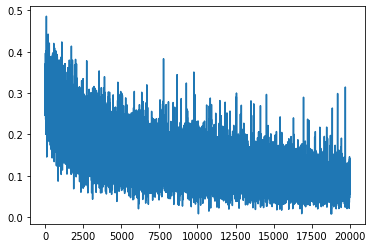

In [12]:
import matplotlib.pyplot as plt

plt.plot(plot_loss)

In [7]:
plot_loss

[0.0004722132347524166,
 0.0008227253177513679,
 0.0006286689313128591,
 0.0008222491014748812,
 0.00047676395624876025,
 0.0008217333039889733,
 0.0006277459324337542,
 0.0008211776924630007,
 0.0006220290088094771,
 0.0003515034622978419,
 0.0006214334862306714,
 0.000820026732981205,
 0.0004827430471777916,
 0.0008193917262057463,
 0.00048240949399769306,
 0.0008189155875394741,
 0.00033330472393168346,
 0.0015107352519407868,
 0.0019531067227944732,
 0.00150972418487072,
 0.0019514422165229917,
 0.0008169312495738268,
 0.001950075151398778,
 0.0015072260284796357,
 0.000979532798131307,
 0.0008156215772032738,
 0.00038079434307292104,
 0.0015052632661536336,
 0.0009780251421034336,
 0.0015041332226246595,
 0.00030444437064803566,
 0.001502824597992003,
 0.00039667511979738873,
 0.0015017538098618388,
 0.000975724154462417,
 0.00150074262637645,
 0.000975009985268116,
 0.0014996721874922514,
 0.0009742958936840296,
 0.000811136948565642,
 0.0019376520067453384,
 0.000453644548542797

Evaluate

In [13]:
s = sentences[8]
s_enc = enc([s])
_, s_pred = dec(s_enc)
s_pred

[[array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]),
  array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])]]

In [10]:
s

['Located', 'East', 'Landmark', 'West']